<a href="https://colab.research.google.com/github/radu-dumitru/micrograd_from_scratch/blob/main/micrograd_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import math
from graphviz import Digraph
import random

In [11]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data ** other, (self, ), f'**{other}')

    def _backward():
      self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other ** -1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other ): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2 * x) -1) / (math.exp(2 * x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t ** 2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def backward(self):
    # topological sort = a laying out a graph such that all the edges go only from left to right
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [12]:
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format = 'svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

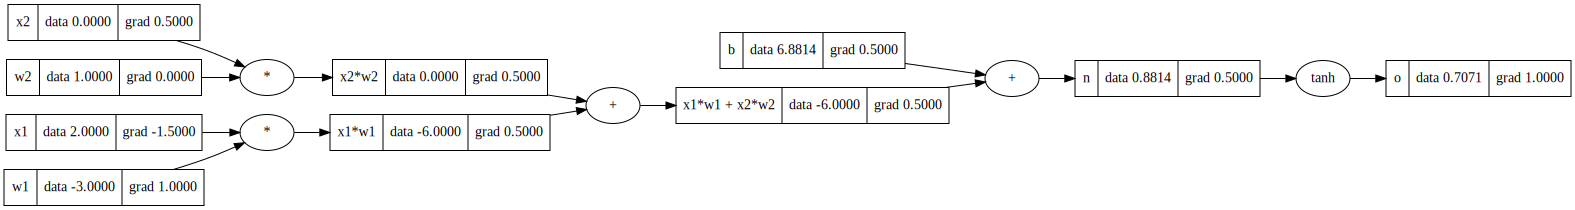

In [13]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.backward()
draw_dot(o)


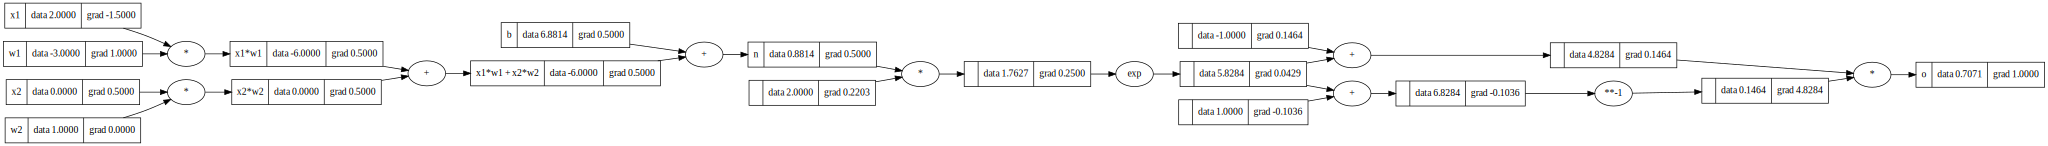

In [14]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2 * n).exp()
o = (e - 1) / (e + 1)

o.label = 'o'

o.backward()
draw_dot(o)

In [15]:
class Neuron:

  def __init__(self, nin): # nin = number of inputs
    # w = weights
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    # b = bias
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    # w * x + b
    # w * x is a dot product
    # x is an array of values

    act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()

    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    # nout = how many neurons you want in this layer
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    params = []
    for neuron in self.neurons:
      ps = neuron.parameters()
      params.extend(ps)
    return params

class MLP:

  def __init__(self, nin, nouts):
    # nouts is a list and defines the sizes of all the layers that we want in our MLP
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [16]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

# draw_dot(n(x))

n.parameters()

[Value(data=0.8583954846738899),
 Value(data=-0.4874801623418863),
 Value(data=0.42483543114579625),
 Value(data=0.2547243794670693),
 Value(data=0.591540047804157),
 Value(data=0.656885287711124),
 Value(data=-0.24801038952903842),
 Value(data=0.7552336661997923),
 Value(data=0.8069198814230787),
 Value(data=0.5166173994237788),
 Value(data=-0.7551468441919453),
 Value(data=-0.019087814281301574),
 Value(data=-0.32168354873975313),
 Value(data=0.5218700711249351),
 Value(data=-0.885807129940271),
 Value(data=-0.2456059356498601),
 Value(data=0.9125222911703728),
 Value(data=0.015200989912675045),
 Value(data=-0.5290692922746498),
 Value(data=-0.09004709944570632),
 Value(data=0.31152874921164164),
 Value(data=-0.1931694366166592),
 Value(data=0.7319290767756177),
 Value(data=0.20121014215274968),
 Value(data=0.7821962206811632),
 Value(data=-0.6880069131131614),
 Value(data=0.17055830140074968),
 Value(data=0.1842590633309189),
 Value(data=0.4211890695592291),
 Value(data=-0.448014605

In [17]:
# dataset

xs = [
    [2.0, 3.0, -1.0], # the network should return 1.0
    [3.0, -1.0, 0.5], # the network should return -1.0
    [0.5, 1.0, 1.0],  # the network should return -1.0
    [1.0, 1.0, -1.0]  # the network should return 1.0
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

for k in range(20):
  # forward pass
  ypred = [n(x) for x in xs]

  # loss = a single number that measures the total performance of your neural net, it measures how well the neural net is performing
  # ygt = y ground truth
  # yout = y output
  # mean squared error
  # you only get 0 when yout is equal to ygt (the prediction is the target)
  # the more off we are the greater the loss will be, we want low loss
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.05 * p.grad

  print(k, loss.data)

0 4.201493193263088
1 1.1456143790130844
2 0.6439459343958333
3 0.46913024332072717
4 0.3659276691102492
5 0.29535945361425353
6 0.24495160764461754
7 0.20762159093031574
8 0.17912524223974574
9 0.15681026023125771
10 0.13895482268167658
11 0.12440271535313588
12 0.11235406376945298
13 0.10224082421297792
14 0.09365016833927302
15 0.08627587909498514
16 0.07988665747653091
17 0.07430493828874266
18 0.0693924105481303
19 0.06503991876347621


In [19]:
ypred

[Value(data=0.8895240459692425),
 Value(data=-0.911323443785704),
 Value(data=-0.8434723024045939),
 Value(data=0.8569247379596177)]